In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
import math
import os

import torch
import plotly.express as px

from train import evaluate_model_copy, CopyConfig, inference_generate
from rnn import RNN, GRULayer

torch.manual_seed(8)
device = "cpu"

In [2]:
# 1024 achieved 1.0 no issues, 256 took some tries and the best is at: "run_256_fixed_lower_wdlr_ctd". 
best_model_dict = {1024:"run_1024_fixed", 256: "run_256_fixed_lower_wdlr_ctd", 128: "run_128_fixed_lowerwdlr_ctd"}
d_hidden = 128
run_name = best_model_dict[d_hidden]
# run_name = "run_1024_fixed"
copy_test_cfg = CopyConfig(run_name=run_name, d_hidden=d_hidden, gru=True)

model = RNN(31, copy_test_cfg.d_hidden, out_size=30, 
            out_act= lambda x: x, use_gru=copy_test_cfg.gru)
model.load_state_dict(torch.load(f"models/copy_train/{copy_test_cfg.run_name}/{copy_test_cfg.run_name}.ckpt", weights_only=True, map_location=device))

ModuleList(
  (0): GRULayer(
    (input_to_reset): Linear(in_features=31, out_features=128, bias=False)
    (hidden_to_reset): Linear(in_features=128, out_features=128, bias=True)
    (input_to_update): Linear(in_features=31, out_features=128, bias=False)
    (hidden_to_update): Linear(in_features=128, out_features=128, bias=True)
    (input_to_new): Linear(in_features=31, out_features=128, bias=False)
    (hidden_to_new): Linear(in_features=128, out_features=128, bias=True)
  )
  (1): Linear(in_features=128, out_features=30, bias=True)
)


<All keys matched successfully>

In [4]:
evaluate_model_copy(copy_test_cfg, model)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:22<00:00, 218.94it/s]


(5.770061691056902e-05, 1.0)

plot gru gate movement

In [5]:
def plot_update_gate_heatmap(model, sequence, loss_mask, 
                             layer=-1, n_channels=-1):
    # Run forward with gate recording enabled
    outputs, h_t, r_t_all, z_t_all = inference_generate(model, sequence, 
                                                        discrete=True,
                                                        record_gates=True)


    layers, batch_size, seq_len, hidden_size = z_t_all.shape
    n_channels = hidden_size if n_channels <0 else n_channels
    if layer > 0:
        z_t_all, r_t_all = z_t_all[layer].unsqueeze(0), r_t_all[layer].unsqueeze(0)


    mask = loss_mask.unsqueeze(0).unsqueeze(-1) # (1, b, l, 1)
    mask = torch.cat([torch.ones((1, batch_size, sequence.size(1), 1)), mask], dim=2)
    z_t_all_masked = z_t_all * mask  # invalid positions become 0
    r_t_all_masked = r_t_all * mask

     # Count valid positions per layer, timestep, and hidden unit across batches
    valid_counts = mask.sum(dim=1)  # sum over batch dimension, shape (1, seq_len, 1)
    valid_counts = valid_counts.clamp(min=1)  # avoid division by zero
    
    # Sum over batches to get total activations per layer, timestep, hidden unit
    z_t_sum = z_t_all_masked.sum(dim=1)  # sum over batch dimension, shape (layers, seq_len, hidden_size)
    r_t_sum = r_t_all_masked.sum(dim=1)
    
    # Average by dividing sum by counts of valid batches
    # Note: valid_counts shape (1, seq_len, 1) broadcasts over layers and hidden_size
    z_t_avg = z_t_sum / valid_counts
    r_t_avg = r_t_sum / valid_counts

    # Plot one heatmap per layer
    for layer in range(layers):
        plt.figure(figsize=(10, 6))
        # Transpose so x axis = time steps, y axis = hidden units
        plt.imshow(z_t_avg[layer][:, :n_channels].T.cpu(), aspect='auto', cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(label="Update gate z_t")
        plt.xlabel("Time step")
        plt.ylabel("Hidden unit")
        plt.title(f"Update Gate Activations for Layer {layer}")
        plt.show()
    
    for layer in range(layers):
        plt.figure(figsize=(10, 6))
        # Transpose so x axis = time steps, y axis = hidden units
        plt.imshow(r_t_avg[layer][:, :n_channels].T.cpu(), aspect='auto', cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(label="Update gate z_t")
        plt.xlabel("Time step")
        plt.ylabel("Hidden unit")
        plt.title(f"Reset Gate Activations for Layer {layer}")
        plt.show()

In [6]:
# data to viz:
test_dataset = torch.load(f"data/copy_test/{copy_test_cfg.run_name}.pt")
batches = [1]
test_data = [test_dataset[batch] for batch in batches]
test_data, test_loss_masks = zip(*test_data)
test_data, test_loss_masks = torch.stack(test_data), torch.stack(test_loss_masks)

### Model 128 gate plot

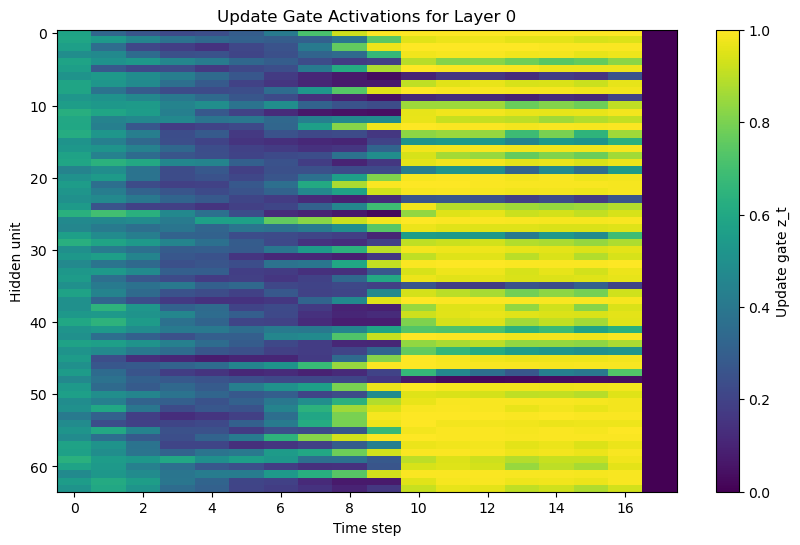

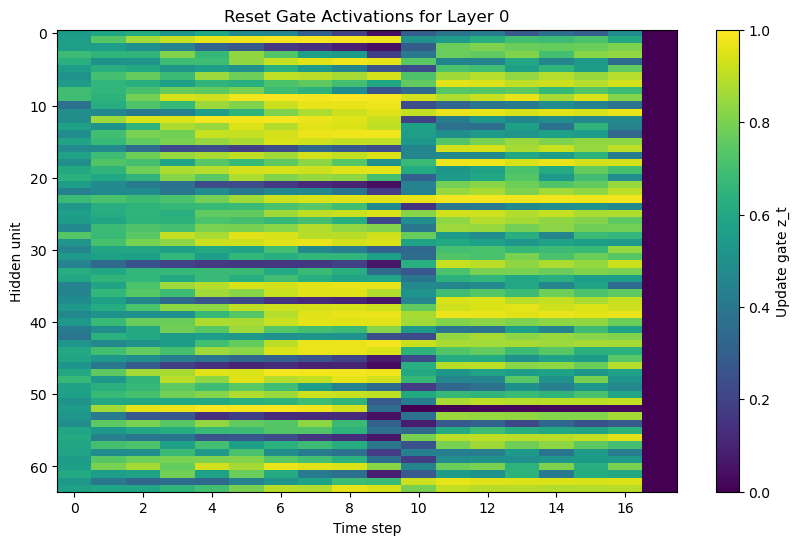

In [7]:
plot_update_gate_heatmap(model, test_data, test_loss_masks, n_channels=64)

### Model 256 gate plot

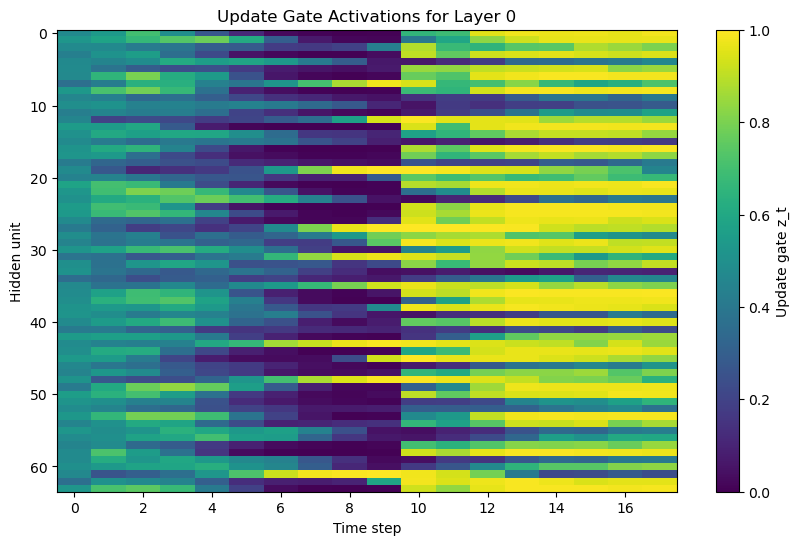

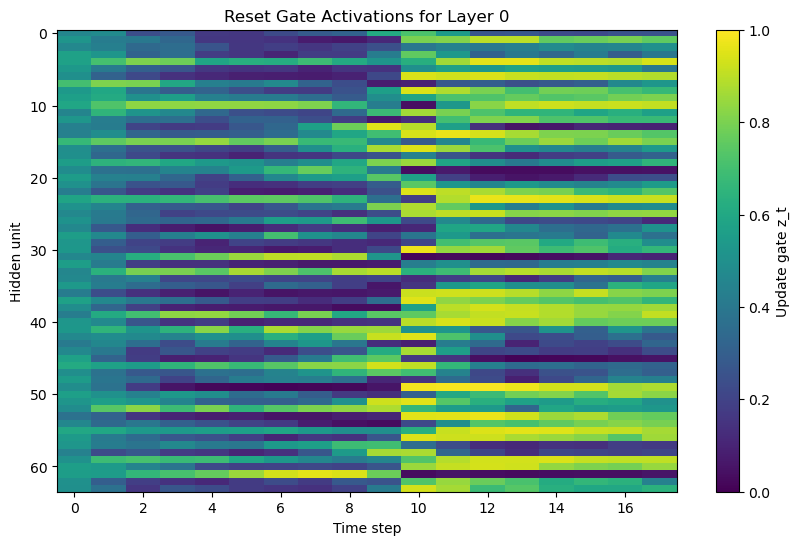

In [27]:

plot_update_gate_heatmap(model, test_data, test_loss_masks, n_channels=64)

### Model 1024 gate plot

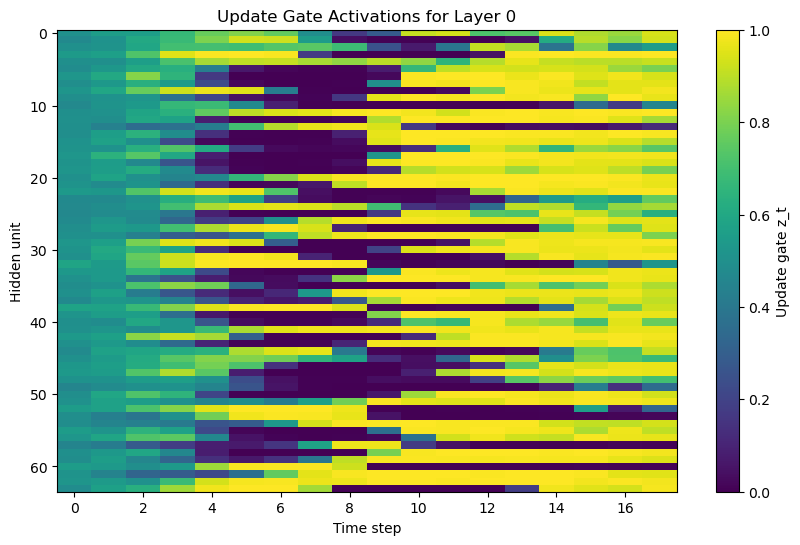

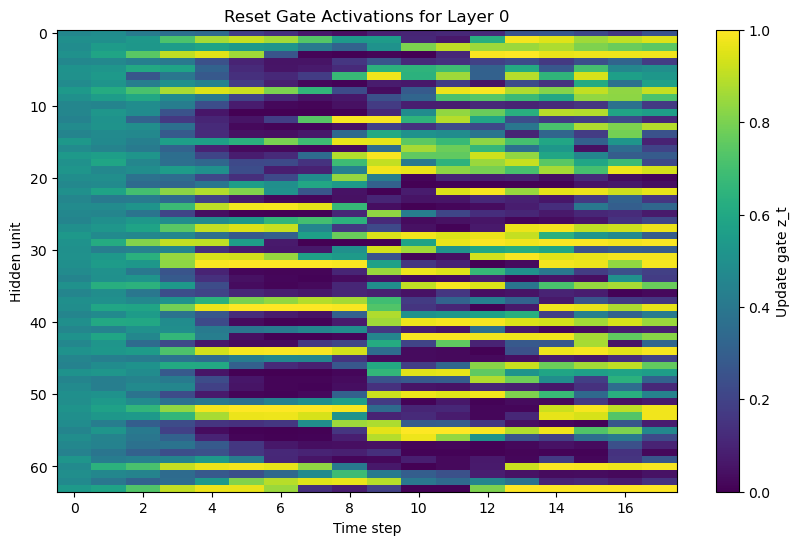

In [23]:
plot_update_gate_heatmap(model, test_data, test_loss_masks, n_channels=64)